In [1]:
import pandas as pd
import traceback

from bs4 import BeautifulSoup
from urllib.request import urlopen, Request

from time import sleep

import re
import json
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
BANK_SCRIPS = ['HDFCBANK','ICICIBANK','AXISBANK','KOTAKBANK','SBIN','CANBK']
IT_SCRIPS = ['INFY', 'HCLTECH','LTIM', 'TCS','LTTS', 'WIPRO' ]
# IT_SCRIPS = ['OLECTRA','KIRLOSBROS','MAZDOCK','JBMA','GLENMARK','ZENTEC','FACT','APARINDS','NEULANDLAB','RKFORGE','TITAGARH','ZENSARTECH' ]
# IT_SCRIPS = ['OLECTRA']
SCRIPS = IT_SCRIPS

## Login

In [3]:
import requests

LOGIN_URL = 'https://www.screener.in/login/'
headers = {
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7',
    'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.99 Safari/537.36'
}

response = requests.get(LOGIN_URL, headers=headers, verify=False)
headers['cookie'] = '; '.join([x.name + '=' + x.value for x in response.cookies])
headers['content-type'] = 'application/x-www-form-urlencoded'
headers

{'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7',
 'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.99 Safari/537.36',
 'cookie': 'csrftoken=gKMA0mIlZv66WhFucPIumeBxEanZAdHf',
 'content-type': 'application/x-www-form-urlencoded'}

## Trying with login

In [4]:
payload = {
    'username': 'Jeevan2961@gmail.com',
    'password': 'Screener@6562!'
}

response = requests.post(LOGIN_URL, data=payload, headers=headers, verify=False)
headers['cookie'] = '; '.join([x.name + '=' + x.value for x in response.cookies])

In [5]:
import requests

url = "https://www.screener.in/login/?csrftoken="

payload = {
    'username': 'Jeevan2961@gmail.com',
    'password': 'Screener@6562!'
}
headers = {
  'Cookie': 'csrftoken=QgS5auLp8rXExwxR6Tladmx3gEDa9aOV; sessionid=cckmtq1phsp4heuk5m122qp9mwbjmy4k'
}

response = requests.request("GET", url, headers=headers, data=payload)


In [6]:
import sys
import requests

URL = 'https://www.screener.in/login/'

client = requests.session()

# Retrieve the CSRF token first
client.get(URL)  # sets cookie
if 'csrftoken' in client.cookies:
    csrftoken = client.cookies['csrftoken']
else:
    # older versions
    csrftoken = client.cookies['csrf']

login_data = dict(username="Jeevan2961@gmail.com", password="Screener@6562!", csrfmiddlewaretoken=csrftoken, next='/')
r = client.post(URL, data=login_data, headers=dict(Referer=URL))

In [7]:
r.cookies

<RequestsCookieJar[Cookie(version=0, name='csrftoken', value='fc9HZBkLQgIrED04AOMe37fwkgaAIORp', port=None, port_specified=False, domain='www.screener.in', domain_specified=False, domain_initial_dot=False, path='/', path_specified=True, secure=True, expires=1726578659, discard=False, comment=None, comment_url=None, rest={'SameSite': 'Lax'}, rfc2109=False)]>

# WEB SCRAPING

In [8]:
BASE_URL = 'https://www.screener.in/company/'

def extract_table_by_class(soup, section_id, class_name):
    section_html = soup.find('section',{'id': section_id})
    table_html = section_html.find('table',{'class': class_name})

    headers = []
    for header in table_html.find_all('th'):
        headers.append(  header.text or 'Type')

    table_df = pd.DataFrame(columns = headers)

    for row_element in table_html.find_all('tr')[1:]:
            row_data = row_element.find_all('td')
            row = [tr.text.strip() for tr in row_data]
            length = len(table_df)
            table_df.loc[length] = row 
            
    return table_df
    

def fetch_number_span(list_element):
    num_span = list_element.find('span',{'class':'number'})

    num_span = num_span.text.replace(',', '')
    return float(num_span) if (num_span != '') else 0.0
    
def extract_scrip_ratios(soup, soup1, div_class, ul_id):
    div_html = soup.find('div',{'class': div_class})
    ul_html = div_html.find('ul',{'id': ul_id})
    # Find all <li> elements in quick-ratios api
    li_html = soup1.findAll('li')
    current_price = 0
    high = 0.0
    low = 0.0
    dividend_yield = 0.0
    pe = 0.0
    roe = 0.0
    roce = 0.0
    market_cap = 0.0
    book_value = 0.0
    face_value = 0.0
    equity_return = 0.0
    debt_equity = 0.0
    promoter_holding = 0.0
    roe_10yr = 0.0
    eps = 0.0
    eps_last_year = 0.0
    peg_ratio = 0.0
    eps_preceding_year = 0.0
    debt = 0.0
    prom_hold_change = 0.0
    industy_pe = 0.0
    sales_growth = 0.0
    profit_growth = 0.0
    price_sales = 0.0
    
    scrip_data = pd.Series()
    
    for li in ul_html.find_all("li"):
        name_span = li.find('span',{'class':'name'})
        
        if 'Current Price' in name_span.text: 
            current_price = fetch_number_span(li)

        if 'High / Low' in name_span.text:
            num_spans = li.find_all('span',{'class':'number'})
            if(len(num_spans) == 2):
                high_num = num_spans[0].text.replace(',', '')
                low_num = num_spans[1].text.replace(',', '')
                high = float(high_num) if (high_num != '') else 0.0
                low = float(low_num) if (low_num != '') else 0.0 
                
        if 'Market Cap' in name_span.text: 
            market_cap = fetch_number_span(li)
            
        if 'Stock P/E' in name_span.text:
            pe = fetch_number_span(li) 
            
        if 'Dividend Yield' in name_span.text:
            dividend_yield = fetch_number_span(li) 
            
        if 'ROCE' in name_span.text:
            roce = fetch_number_span(li) 
            
        if 'ROE' in name_span.text:
            roe = fetch_number_span(li) 
        
        if 'Book Value' in name_span.text: 
            book_value = fetch_number_span(li)
            
        if 'Face Value' in name_span.text:
            face_value = fetch_number_span(li)

    for li in li_html:
        name_span = li.find('span',{'class':'name'})

        if 'Return on equity' in name_span.text:
            equity_return = fetch_number_span(li) 
            
        if 'Debt to equity' in name_span.text:
            debt_equity = fetch_number_span(li) 
            
        if 'Promoter holding' in name_span.text:
            promoter_holding = fetch_number_span(li)

        if 'ROE 10Yr' in name_span.text:
            roe_10yr = fetch_number_span(li) 

        if 'EPS' in name_span.text:
            eps = fetch_number_span(li) 

        if 'EPS last year' in name_span.text:
            eps_last_year = fetch_number_span(li) 

        if 'PEG Ratio' in name_span.text:
            peg_ratio = fetch_number_span(li) 

        if 'EPS preceding year' in name_span.text:
            eps_preceding_year = fetch_number_span(li) 

        if 'Debt' in name_span.text:
            debt = fetch_number_span(li) 

        if 'Change in Prom Hold' in name_span.text:
            prom_hold_change = fetch_number_span(li) 

        if 'Industry PE' in name_span.text:
            industy_pe = fetch_number_span(li) 

        if 'Sales growth' in name_span.text:
            sales_growth = fetch_number_span(li) 

        if 'Profit growth' in name_span.text:
            profit_growth = fetch_number_span(li) 

        if 'Price to Sales' in name_span.text:
            price_sales = fetch_number_span(li) 


    scrip_data['Price'] = current_price
    scrip_data['High'] = high
    scrip_data['Low'] = low
    scrip_data['Market_Cap'] = market_cap
    scrip_data['PE'] = pe
    scrip_data['Dividend'] = dividend_yield
    scrip_data['ROCE'] = roce
    scrip_data['ROE'] = roe
    scrip_data['Book_Value'] = book_value
    scrip_data['Face_Value'] = face_value
    scrip_data['Return_on_equity'] = equity_return
    scrip_data['Debt_to_equity'] = debt_equity
    scrip_data['Promoter_holding'] = promoter_holding
    scrip_data['ROE_10Yr'] = roe_10yr
    scrip_data['EPS'] = eps
    scrip_data['EPS_last_year'] = eps_last_year
    scrip_data['PEG_Ratio'] = peg_ratio
    scrip_data['EPS_preceding_year'] = eps_preceding_year
    scrip_data['Debt'] = debt
    scrip_data['Change_in_Prom_Hold'] = prom_hold_change
    scrip_data['Industry_PE'] = industy_pe
    scrip_data['Sales_growth'] = sales_growth
    scrip_data['Profit_growth'] = profit_growth
    scrip_data['Price_to_Sales'] = price_sales
    return scrip_data


def fetch_scrip_data(scrip, section_id):
    link = f'{BASE_URL}{scrip}/consolidated'
    hdr = {'User-Agent':'Mozilla/5.0','Cookie':'csrftoken=QgS5auLp8rXExwxR6Tladmx3gEDa9aOV; sessionid=cckmtq1phsp4heuk5m122qp9mwbjmy4k'}
    req = Request(link,headers=hdr)
    
    table_df = None
    scrip_data = pd.Series()
    try:
        page=urlopen(req)
        soup_consolidated = BeautifulSoup(page)
        warehouse_id = soup_consolidated.find('div',{'id': 'company-info'})['data-warehouse-id'] # fetching warehouse id

        url = f"https://www.screener.in/api/company/{warehouse_id}/quick_ratios/"
        response = requests.request("GET", url, headers=hdr)
        html_data = response.text
        soup_quick_ratio = BeautifulSoup(html_data, 'html.parser')

        scrip_data = extract_scrip_ratios(soup_consolidated, soup_quick_ratio, 'company-ratios', 'top-ratios')
        try:
            table_df = extract_table_by_class(soup_consolidated, section_id, 'data-table responsive-text-nowrap')
        except:
            table_df = extract_table_by_class(soup_consolidated, section_id, 'data-table')
    except:
        print(f'EXCEPTION THROWN: UNABLE TO FETCH DATA')

    return scrip_data, table_df


def extract_last_n_years_pl(pl_df, n_years):
    # Extract data for all years from the column names
    mon_year_regex = re.compile('([A-Z][a-z]{2}) (\d{4})')
    years = {}
    for col in list(pl_df.columns):
        res = re.search(mon_year_regex,col)
        if res:
            years[res.group(2)] = col

    # Get only the last n (PROFIT_LOSS_YEARS) years for checking the P&L 
    years_list = sorted(years.keys())
    years_list = years_list[-n_years:]
    cols = [years[year] for year in years_list]
    pl_values = pl_df[cols].iloc[0, :].values.tolist()
    pl_values = [float(x.replace(',', '')) for x in pl_values] 
    return pl_values


def fetch_peers_table(scrip):
    link = f'{BASE_URL}{scrip}/consolidated'
    hdr = {'User-Agent':'Mozilla/5.0','Cookie':'csrftoken=QgS5auLp8rXExwxR6Tladmx3gEDa9aOV; sessionid=cckmtq1phsp4heuk5m122qp9mwbjmy4k'}
    req = Request(link,headers=hdr)
    page=urlopen(req)
    soup = BeautifulSoup(page)
    company_id = soup.find('div',{'id': 'company-info'})['data-warehouse-id'] # fetching company id

    url = f"https://www.screener.in/api/company/{company_id}/peers/"
    response = requests.request("GET", url, headers=hdr)
    html_data = response.text
    soup_peers = BeautifulSoup(html_data, 'html.parser')
    table_html = soup_peers.find('table',{'class': "data-table text-nowrap striped mark-visited"})

    headers = []
    for header in table_html.find_all('th'):
        headers.append(  header.text or 'Type')

    table_df = pd.DataFrame(columns = headers)

    for row_element in table_html.find_all('tr')[1:]:
            row_data = row_element.find_all('td')
            row = [tr.text.strip() for tr in row_data]
            length = len(table_df)
            table_df.loc[length] = row 
            
    return table_df

In [9]:
scrip_data, profit_loss_df = fetch_scrip_data('TCS', 'profit-loss')
scrip_data

Price                     3606.00
High                      3619.00
Low                       2926.00
Market_Cap             1319509.00
PE                          30.20
Dividend                     1.33
ROCE                        59.10
ROE                         46.90
Book_Value                 247.00
Face_Value                   1.00
Return_on_equity            46.90
Debt_to_equity               0.09
Promoter_holding            72.30
ROE_10Yr                    38.60
EPS                        105.00
EPS_last_year              115.00
PEG_Ratio                    2.90
EPS_preceding_year         105.00
Debt                      7688.00
Change_in_Prom_Hold          0.00
Industry_PE                 27.90
Sales_growth                16.60
Profit_growth               12.80
Price_to_Sales               5.69
dtype: float64

# CHECK IF CURRENT PRICE IS BELOW PREVIOUS HIGH

In [10]:
# Check if current price is below the 52-week high with a certain threshold
# Eg: If current price is 100, 52-week high is 120, threshold is 10%, then return True
#     If current price is 100, 52-week high is 105, threshold is 10%, then return False
def check_current_below_high_threshold(current,high, threshold_percent):
    below_threshold = False
    if ((current < high) & ((high-current)/high*100 > threshold_percent)):
        below_threshold = True
    return below_threshold   

# PROFIT/LOSS BASED STRATEGY

STRATEGY:

BUY recommendation if:
1. Net profit for the company has been increasing consistently in the last few (config) years
2. Current market price is atleast 10% below the 52-week high (stock is not trading around all time high)

In [11]:
# PROFIT-LOSS STRATEGY - CONFIG
PROFIT_LOSS_YEARS = 3
SCREENER_ROW_PL = 'Net Profit +' # or can be 'Profit before tax'
CURRENT_HIGH_THRESHOLD_PERCENT = 10

In [12]:
def apply_pl_strategy(scrip, current_price, scrip_high, profit_loss_df, high_threshold_percent):
    
#     STRATEGY:
#     BUY recommendation if:
#         1. Profit/Loss for the company has been increasing consistently in the last few years.
#         2. Current market price is below 10% of 52-week high

    # SET DEFAULT TO STOCK AS NO-ACTION
    strategy_result = 'WAIT'
    try: 

        # CHECK IF REQUIRED VALUES COULD BE SCRAPED
        if (current_price is None or current_price == 0.0 or 
            scrip_high is None or scrip_high == 0.0):
            strategy_result = 'NOT FOUND'

        else:
            profit_loss_df = profit_loss_df[profit_loss_df['Type'] == SCREENER_ROW_PL]
            last_pl_list = extract_last_n_years_pl(profit_loss_df, PROFIT_LOSS_YEARS)
            print(f'Profit/Loss for last {PROFIT_LOSS_YEARS} years:{last_pl_list}')
            print(f'Current Price:{current_price}, 52-week High:{scrip_high}, Threshold%: {high_threshold_percent}%')

            # CHECK IF PROFIT-LOSS IS CONSISTENTLY INCREASING
            if(last_pl_list == sorted(last_pl_list)):
                # IF YES, CHECK IF CURRENT MARKET VALUE IS NOT AT ALL TIME HIGH
                if check_current_below_high_threshold(current_price, scrip_high, high_threshold_percent):
                    # BUY RECOMMENDATION
                    strategy_result = 'BUY'
    except Exception as e:
        print(f"UNABLE TO APPLY PROFIT-LOSS STRATEGY ON {scrip}. Exception: {e}")
        print(traceback.format_exc())

    return strategy_result

# SCRAPE THE DATA

In [17]:
final_df = pd.DataFrame({'Symbol':SCRIPS},
                        columns=['Symbol','Market_Cap','Price','High','Low','PE','ROE','ROCE','Dividend','Book_Value','Face_Value','Return_on_equity','Debt_to_equity','Promoter_holding','ROE_10Yr','EPS','EPS_last_year','PEG_Ratio','EPS_preceding_year','Debt','Change_in_Prom_Hold','Industry_PE','Sales_growth','Profit_growth','Price_to_Sales','STRATEGY_PL']).set_index('Symbol')


# LOOP THROUGH EACH SCRIP
for scrip in SCRIPS:
    print(f"\nSYMBOL: {scrip}")
    scrip_data, profit_loss_df = fetch_scrip_data(scrip, 'profit-loss')
    for index, value in scrip_data.iteritems():
        final_df[index][scrip] = value
    strategy_result = apply_pl_strategy(scrip, scrip_data['Price'], scrip_data['High'], profit_loss_df, CURRENT_HIGH_THRESHOLD_PERCENT)
    print(f"APPLYING PROFIT/LOSS STRATEGY ON {scrip}: {strategy_result}")
    final_df['STRATEGY_PL'][scrip] = strategy_result
    #sleep(2) # Add sleep if TOO MANY REQUESTS error (Error Code: 429) is thrown

display(final_df)


SYMBOL: INFY
Profit/Loss for last 3 years:[19423.0, 22146.0, 24108.0]
Current Price:1492.0, 52-week High:1673.0, Threshold%: 10%
APPLYING PROFIT/LOSS STRATEGY ON INFY: BUY

SYMBOL: HCLTECH
Profit/Loss for last 3 years:[11169.0, 13523.0, 14845.0]
Current Price:1305.0, 52-week High:1311.0, Threshold%: 10%
APPLYING PROFIT/LOSS STRATEGY ON HCLTECH: WAIT

SYMBOL: LTIM
Profit/Loss for last 3 years:[1938.0, 3950.0, 4410.0]
Current Price:5514.0, 52-week High:5593.0, Threshold%: 10%
APPLYING PROFIT/LOSS STRATEGY ON LTIM: WAIT

SYMBOL: TCS
Profit/Loss for last 3 years:[32562.0, 38449.0, 42303.0]
Current Price:3606.0, 52-week High:3619.0, Threshold%: 10%
APPLYING PROFIT/LOSS STRATEGY ON TCS: WAIT

SYMBOL: LTTS
Profit/Loss for last 3 years:[666.0, 961.0, 1174.0]
Current Price:4663.0, 52-week High:4807.0, Threshold%: 10%
APPLYING PROFIT/LOSS STRATEGY ON LTTS: WAIT

SYMBOL: WIPRO
Profit/Loss for last 3 years:[10868.0, 12243.0, 11366.0]
Current Price:436.0, 52-week High:444.0, Threshold%: 10%
APPLYI

,Market_Cap,Price,High,Low,PE,ROE,ROCE,Dividend,Book_Value,Face_Value,...,EPS_last_year,PEG_Ratio,EPS_preceding_year,Debt,Change_in_Prom_Hold,Industry_PE,Sales_growth,Profit_growth,Price_to_Sales,STRATEGY_PL
Symbol,,,,,,,,,,,,,,,,,,,,,
INFY,619154.0,1492.0,1673.0,1185.0,25.1,31.8,40.7,2.28,179.0,5.0,...,58.1,2.9,52.6,8483.0,-0.2,27.9,17.2,10.8,4.12,BUY
HCLTECH,354133.0,1305.0,1311.0,882.0,23.5,23.0,28.3,3.68,241.0,2.0,...,54.7,2.09,49.7,4794.0,0.0,27.9,17.1,11.2,3.4,WAIT
LTIM,163155.0,5514.0,5593.0,4120.0,36.6,28.6,37.7,1.09,615.0,1.0,...,149.0,1.15,225.0,1579.0,-0.02,27.9,72.5,53.3,4.76,WAIT
TCS,1319509.0,3606.0,3619.0,2926.0,30.2,46.9,59.1,1.33,247.0,1.0,...,115.0,2.9,105.0,7688.0,0.0,27.9,16.6,12.8,5.69,WAIT
LTTS,49282.0,4663.0,4807.0,3216.0,39.8,25.0,32.8,0.97,469.0,2.0,...,111.0,2.26,90.7,454.0,-0.05,27.9,23.5,21.8,5.65,WAIT
WIPRO,239460.0,436.0,444.0,352.0,20.6,15.9,17.7,0.23,142.0,2.0,...,20.7,2.84,22.3,17467.0,-0.01,27.9,11.4,0.87,2.61,WAIT


# MARKET CAPITALIZATION PLOT

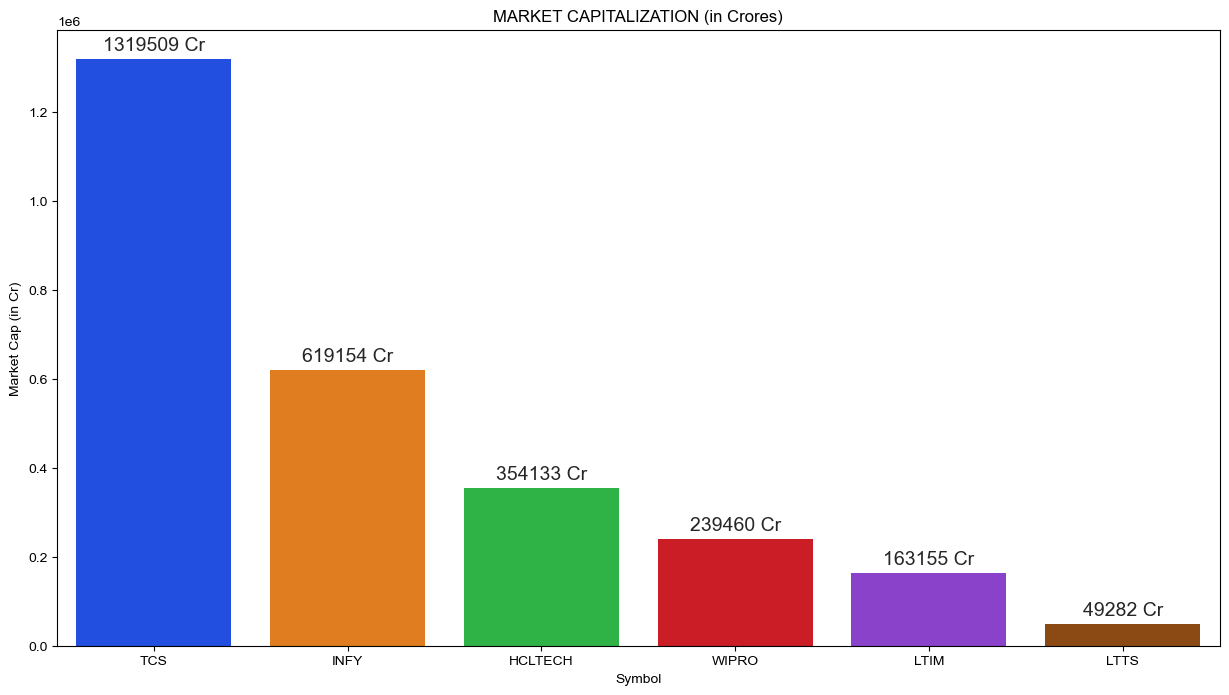

In [18]:
plt.figure(figsize = (15,8))

mark_cap_sorted_df = final_df.sort_values(by='Market_Cap', ascending = False)
ax = sns.barplot(x=mark_cap_sorted_df.index, y=mark_cap_sorted_df['Market_Cap'], palette = 'bright')
ax.set(xlabel="Symbol", ylabel='Market Cap (in Cr)',title = f'MARKET CAPITALIZATION (in Crores)') 
sns.set(font_scale = 1.5)

#annotate axis = seaborn axis
for p in ax.patches:
     ax.annotate("%.0f Cr" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
         ha='center', va='center', fontsize=14,  xytext=(0, 10),
         textcoords='offset points')

# PLOT THE RESULT OF APPLYING THE PROFIT-LOSS STRATEGY

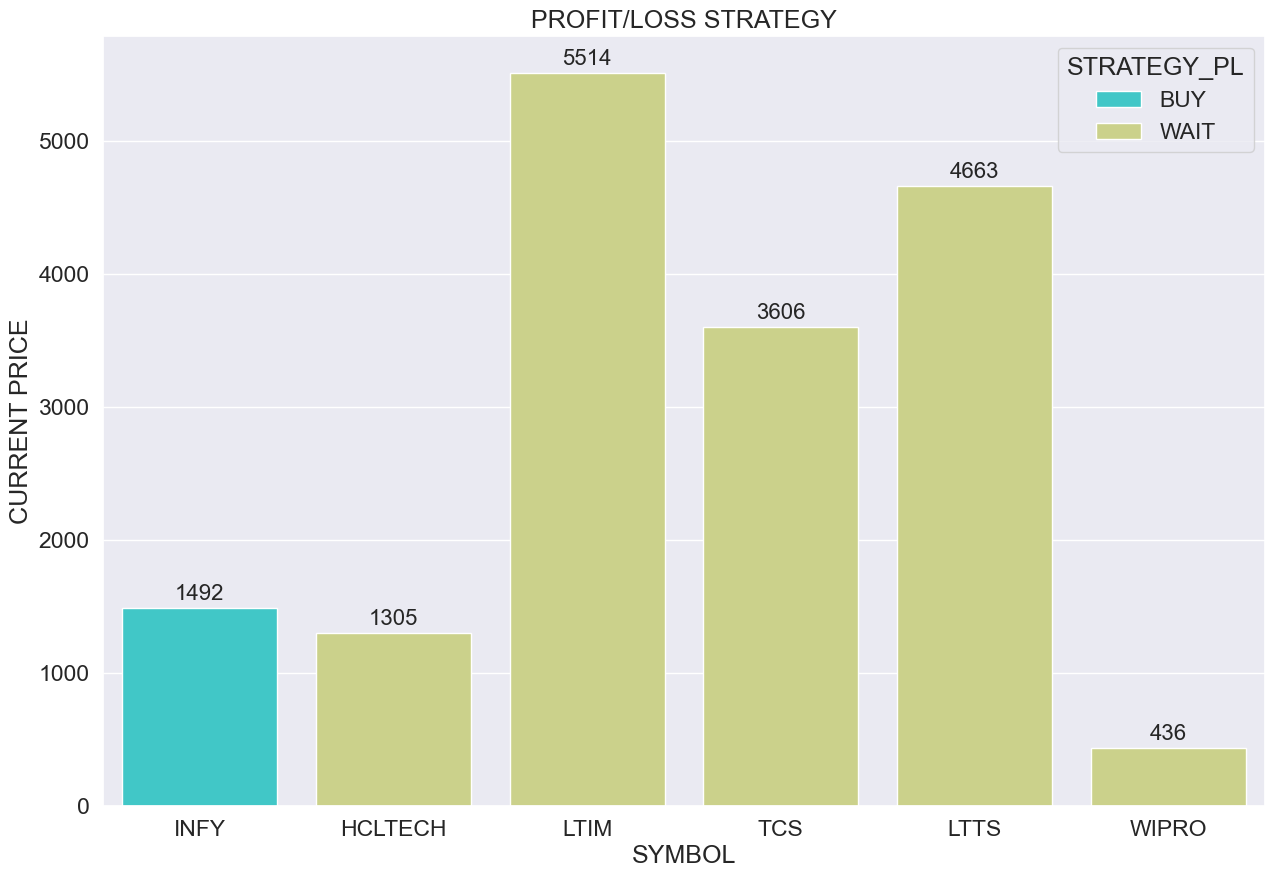

In [19]:
fig = plt.subplots(figsize=(15,10))
ax = sns.barplot(x=final_df.index,y=final_df['Price'],hue=final_df['STRATEGY_PL'],palette='rainbow', dodge=False) 
ax.set(xlabel='SYMBOL', ylabel='CURRENT PRICE', title = 'PROFIT/LOSS STRATEGY')
#annotate axis = seaborn axis
for p in ax.patches:
             ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=16,  xytext=(0, 10),
                 textcoords='offset points')

sns.set(font_scale = 1.5)
plt.show()

# PE - ROE - ROCE COMPARISON PLOT

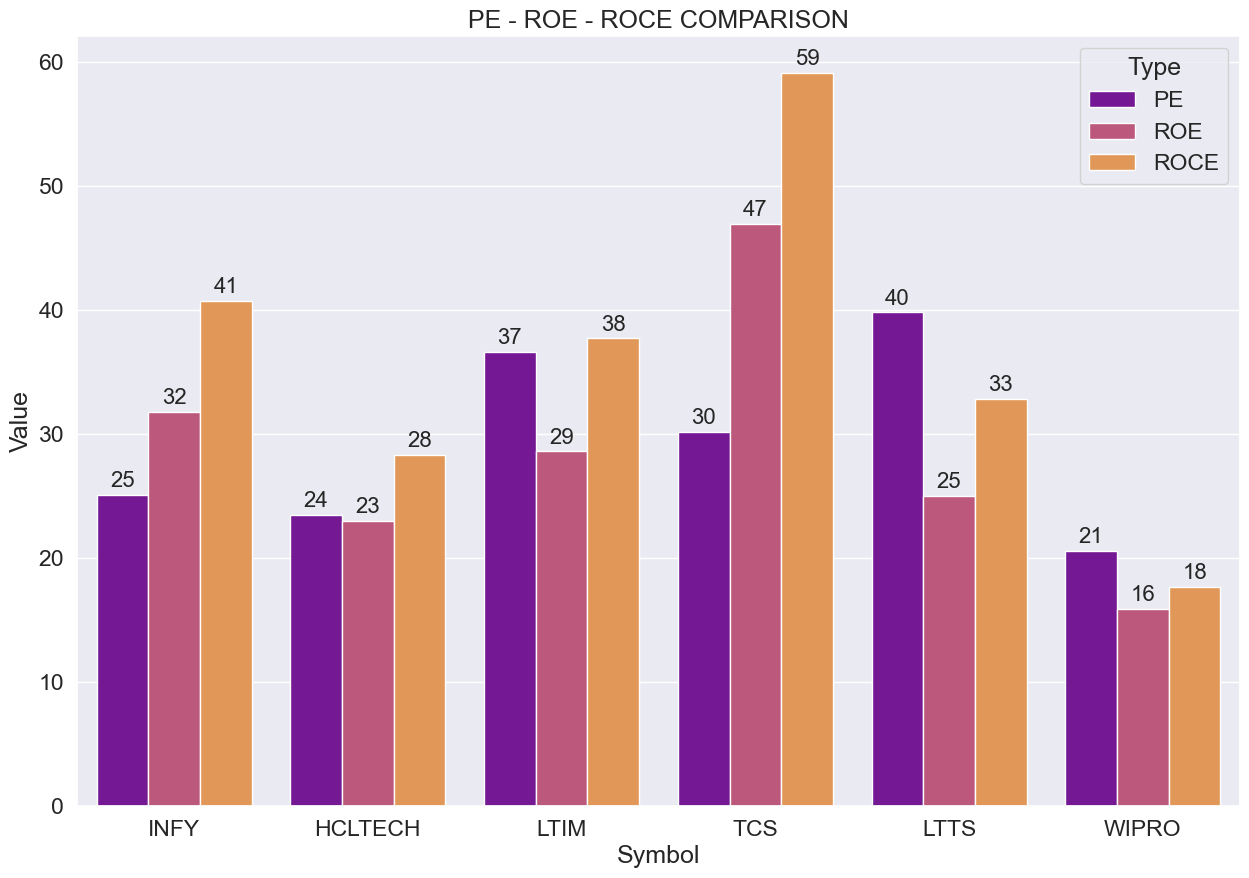

In [20]:
roe_data = pd.DataFrame(final_df['ROE']).rename(columns = {'ROE':'Value'})
roe_data['Type'] = 'ROE'

roce_data = pd.DataFrame(final_df['ROCE']).rename(columns = {'ROCE':'Value'})
roce_data['Type'] = 'ROCE'



pe_data = pd.DataFrame(final_df['PE']).rename(columns = {'PE':'Value'})
pe_data['Type'] = 'PE'

analysis_df = pd.concat([pe_data, roe_data,roce_data])
analysis_df

fig = plt.subplots(figsize=(15,10))

ax = sns.barplot(x=analysis_df.index,
           y=analysis_df['Value'],
           hue=analysis_df['Type'],
           palette = 'plasma')
ax.set( title = 'PE - ROE - ROCE COMPARISON')

for p in ax.patches:
             ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=16,  xytext=(0, 10),
                 textcoords='offset points')
        
plt.show()

# SAMPLE: EXTRACT THE MARKET CAP OF INFOSYS

In [21]:
from bs4 import BeautifulSoup
from urllib.request import urlopen, Request

SCRIP = 'INFY'
link = f'https://www.screener.in/company/{SCRIP}'
hdr = {'User-Agent':'Mozilla/5.0'}
req = Request(link,headers=hdr)
 
try:
    page=urlopen(req)
    soup = BeautifulSoup(page)
    
    div_html = soup.find('div',{'class': 'company-ratios'})
    ul_html = div_html.find('ul',{'id': 'top-ratios'})
    market_cap = 0.0
        
    for li in ul_html.find_all("li"):
        name_span = li.find('span',{'class':'name'})
        if 'Market Cap' in name_span.text: 
            num_span = li.find('span',{'class':'number'})
            num_span = num_span.text.replace(',', '')
            market_cap = float(num_span) if (num_span != '') else 0.0
    
    print(f'MARKET CAPITILIZATION - {SCRIP}: {market_cap} Cr')

except:
    print(f'EXCEPTION THROWN: UNABLE TO FETCH DATA FOR {SCRIP}')

MARKET CAPITILIZATION - INFY: 619154.0 Cr


# Saving Fundamental data Tables in csv

In [14]:
section_id = ['profit-loss', 'balance-sheet', 'quarters', 'cash-flow', 'ratios']
for scrip in SCRIPS:
    print(f"\nSYMBOL: {scrip}")
    for sec_id in section_id:
        scrip_data, df = fetch_scrip_data(scrip, sec_id)
        if df is not None:
            # Remove '\n' and strip leading/trailing spaces from column names
            df.columns = df.columns.str.replace('\n', ' ').str.strip()
            file_name = f"Fundamental_data/{scrip}_{sec_id}.csv"
            df.to_csv(file_name, index=False)
            print(f"Data saved to {file_name}")
        else:
            print(f"No data available for {scrip} - {sec_id}")
    sleep(3)


SYMBOL: INFY
Data saved to Fundamental_data/INFY_profit-loss.csv
Data saved to Fundamental_data/INFY_balance-sheet.csv
Data saved to Fundamental_data/INFY_quarters.csv
Data saved to Fundamental_data/INFY_cash-flow.csv
Data saved to Fundamental_data/INFY_ratios.csv

SYMBOL: HCLTECH
Data saved to Fundamental_data/HCLTECH_profit-loss.csv
Data saved to Fundamental_data/HCLTECH_balance-sheet.csv
Data saved to Fundamental_data/HCLTECH_quarters.csv
Data saved to Fundamental_data/HCLTECH_cash-flow.csv
Data saved to Fundamental_data/HCLTECH_ratios.csv

SYMBOL: LTIM
Data saved to Fundamental_data/LTIM_profit-loss.csv
Data saved to Fundamental_data/LTIM_balance-sheet.csv
Data saved to Fundamental_data/LTIM_quarters.csv
Data saved to Fundamental_data/LTIM_cash-flow.csv
Data saved to Fundamental_data/LTIM_ratios.csv

SYMBOL: TCS
Data saved to Fundamental_data/TCS_profit-loss.csv
Data saved to Fundamental_data/TCS_balance-sheet.csv
Data saved to Fundamental_data/TCS_quarters.csv
Data saved to Funda

In [13]:
# Saving shareholding table
for scrip in SCRIPS:
    print(f"\nSYMBOL: {scrip}")
    scrip_data, df = fetch_scrip_data(scrip, 'shareholding')
    if df is not None:
        # Remove '\n' and strip leading/trailing spaces from column names
        df.columns = df.columns.str.replace('\n', ' ').str.strip()
        file_name = f"Fundamental_data/{scrip}_shareholding.csv"
        df.to_csv(file_name, index=False)
        print(f"Data saved to {file_name}")
    else:
        print(f"No data available for {scrip} - shareholding")


SYMBOL: INFY
Data saved to Fundamental_data/INFY_shareholding.csv

SYMBOL: HCLTECH
Data saved to Fundamental_data/HCLTECH_shareholding.csv

SYMBOL: LTIM
Data saved to Fundamental_data/LTIM_shareholding.csv

SYMBOL: TCS
Data saved to Fundamental_data/TCS_shareholding.csv

SYMBOL: LTTS
Data saved to Fundamental_data/LTTS_shareholding.csv

SYMBOL: WIPRO
Data saved to Fundamental_data/WIPRO_shareholding.csv


In [38]:
# Saving peers comparisons table
for scrip in SCRIPS:
    print(f"\nSYMBOL: {scrip}")
    df = fetch_peers_table(scrip)
    if df is not None:
        # Remove '\n' and ALL spaces in a string, even between words
        df.columns = [re.sub(r"\s+", " ", column, flags=re.UNICODE) for column in df.columns]
        file_name = f"Fundamental_data/{scrip}_peers.csv"
        df.to_csv(file_name, index=False)
        print(f"Data saved to {file_name}")
    else:
        print(f"No peers table available for {scrip}")


SYMBOL: INFY
Data saved to Fundamental_data/INFY_peers.csv

SYMBOL: HCLTECH
Data saved to Fundamental_data/HCLTECH_peers.csv

SYMBOL: LTIM
Data saved to Fundamental_data/LTIM_peers.csv

SYMBOL: TCS
Data saved to Fundamental_data/TCS_peers.csv

SYMBOL: LTTS
Data saved to Fundamental_data/LTTS_peers.csv

SYMBOL: WIPRO
Data saved to Fundamental_data/WIPRO_peers.csv


## Fetching chart datas

In [7]:
BASE_URL = 'https://www.screener.in/company/'
def fetch_price_chart_data(scrip, days, options):
    link = f'{BASE_URL}{scrip}/consolidated'
    hdr = {'User-Agent':'Mozilla/5.0','Cookie':'csrftoken=QgS5auLp8rXExwxR6Tladmx3gEDa9aOV; sessionid=cckmtq1phsp4heuk5m122qp9mwbjmy4k'}
    req = Request(link,headers=hdr)
    page=urlopen(req)
    soup = BeautifulSoup(page)
    company_id = soup.find('div',{'id': 'company-info'})['data-company-id'] # fetching company id
    url = f"https://www.screener.in/api/company/{company_id}/chart/?q={options}&days={days}&consolidated=true"
    response = requests.request("GET", url, headers=hdr)
    json_data = response.json()
    df = json_normalize(json_data['datasets'])
    
    # Create an empty DataFrame to store the reshaped data
    reshaped_data = {}

    # Iterate through each row in the original DataFrame
    for row in df.itertuples():
        label = row.label
        values = row.values
        
        # Iterate through the list of date-value pairs in the "values" column
        for item in values:
            date = item[0]
            value = item[1] if len(item) > 1 else None
            # If the date is not in the reshaped_data dictionary, create a new entry
            if date not in reshaped_data:
                reshaped_data[date] = {}
            
            # Add the value to the corresponding label in the dictionary
            reshaped_data[date][label] = value

    # Create the reshaped DataFrame from the dictionary
    reshaped_df = pd.DataFrame.from_dict(reshaped_data, orient='index')

    # Set the index name to "Date"
    reshaped_df.index.name = "Date"

    # Sort the index
    reshaped_df.sort_index(inplace=True)

    # Display the new DataFrame
    return reshaped_df

In [8]:
options = {'Price' : 'Price-DMA50-DMA200-Volume',
        'PE Ratio' : 'Price+to+Earning-Median+PE-EPS',
        'Market Cap / Sales': 'Market+Cap+to+Sales-Median+Market+Cap+to+Sales-Sales',
        'Sales & Margin' : 'GPM-OPM-NPM-Quarter+Sales',
        'EV / EBITDA' : 'EV+Multiple-Median+EV+Multiple-EBITDA',
        'Price to Book' : 'Price+to+book+value-Median+PBV-Book+value'}

days = {'1m' : 30,
        '6m' : 180,
        '1Yr' : 365,
        '3Yr' : 1095,
        '5Yr' : 1825,
        '10Yr' : 3652,
        'Max' : 10000}

In [13]:
df = fetch_price_chart_data('TCS', days['5Yr'], options['PE Ratio'])
df

,TTM EPS,PE,Median PE = 29.0
Date,,,
2018-08-31,NaN,29.2,29.0
2018-09-07,NaN,29.2,NaN
2018-09-14,NaN,29.1,NaN
2018-09-21,NaN,29.6,NaN
2018-09-28,NaN,30.7,NaN
...,...,...,...
2023-08-04,NaN,28.8,NaN
2023-08-11,NaN,28.9,NaN
2023-08-18,NaN,28.2,NaN
